# Model 3 - UDE Framework (SIR Epidemic)

**System:**
$$\frac{dS}{dt} = -\beta(I) \cdot S$$
$$\frac{dI}{dt} = \beta(I) \cdot S - \gamma I$$
$$\frac{dR}{dt} = \gamma I$$

**Unknown:** Function $\beta(I)$ and Parameter $\gamma$


In [62]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from ude_framework import (
    create_neural_network,
    create_ude,
    UDETrainer,
    UDEEvaluator
)

%matplotlib inline
np.random.seed(42)
torch.manual_seed(42)

print("✓ UDE Framework loaded!")


✓ UDE Framework loaded!


In [76]:
# ============================================================================
# CONFIGURE EVERYTHING HERE
# ============================================================================

# ----------------------------------------------------------------------------
# 1. DATA FILES
# ----------------------------------------------------------------------------
MEASUREMENTS_FILE = 'model_3_measurements.csv'
INITIAL_CONDITIONS_FILE = 'model_3_initial_conditions.csv'

# State variable names (SIR model)
STATE_NAMES = ['S', 'I', 'R']

# Which states are observed in measurements
OBSERVED_STATES = ['I']  # Only I (infected) is measured
OBSERVED_INDICES = [STATE_NAMES.index(name) for name in OBSERVED_STATES]

# ----------------------------------------------------------------------------
# 2. UDE STRUCTURE (partial known + NN for unknown)
# ----------------------------------------------------------------------------
def ude_ode_equations(t, y, nn_outputs, known_params):
    """
    UDE for Model 3 (SIR Epidemic):
    - KNOWN: linear structure
    - UNKNOWN: beta(I) learned by NN (infection rate as function of I)
    - LEARNABLE PARAMETER: gamma (recovery rate)
    
    System equations:
    dS/dt = -beta(I)*S
    dI/dt = beta(I)*S - gamma*I
    dR/dt = gamma*I
    
    State vector: y = [S, I, R]
    """
    S = y[..., 0:1]  # Susceptible
    I = y[..., 1:2]  # Infected
    R = y[..., 2:3]  # Recovered
    
    # Clamp states to prevent negative values (numerical safety)
    S = torch.clamp(S, min=0.0)
    I = torch.clamp(I, min=0.0)
    R = torch.clamp(R, min=0.0)
    
    # Get NN output for beta(I) - already constrained in wrapper
    beta_nn = nn_outputs['beta_nn']
    if beta_nn.dim() > 2:
        beta_nn = beta_nn.squeeze(-1)
    
    # Learnable parameter gamma (recovery rate) - already constrained positive
    gamma = known_params.get('gamma_learnable', torch.tensor(0.001))
    
    # SIR system equations with beta as a function of I
    dS_dt = -beta_nn * S
    dI_dt = beta_nn * S - gamma * I
    dR_dt = gamma * I
    
    return torch.cat([dS_dt, dI_dt, dR_dt], dim=-1)

# Known parameters for UDE (we'll add learnable d later)
KNOWN_PARAMS = {}
# ============================================================================
# 3. NEURAL NETWORK CONFIGURATION
# ============================================================================
NN_INPUT_DIM = 1   # beta depends only on I (the infected population)
NN_OUTPUT_DIM = 1  # outputs beta(I)

def nn_input_extractor(y):
    """Extract only I (second state, index 1) for beta(I)"""
    return y[..., 1:2]  # Returns only I (the infected population)

NN_ARCHITECTURE = 'flexible'
NN_CONFIG = {
    'hidden_dims': [256,256,256,256,256],  # Smaller network for stability
    'activation': 'tanh',
    'final_activation': 'softplus'  # Output in [0, 1], we'll scale it later
}
NN_NAME = 'beta_nn'

# ----------------------------------------------------------------------------
# 4. TRAINING CONFIGURATION
# ----------------------------------------------------------------------------
N_EPOCHS = 500
LEARNING_RATE = 1e-4  # Very conservative learning rate
OPTIMIZER = 'adam'
WEIGHT_DECAY = 1e-3  # L2 regularization for stability
GRAD_CLIP = 10.0  # Strong gradient clipping

SCHEDULER_TYPE = 'plateau'
SCHEDULER_PARAMS = {
    'factor': 0.8,
    'patience': 150,
    'min_lr': 1e-7,
    'verbose': False
}

# Use faster ODE solver with moderate tolerances
ODE_SOLVER = 'rk4'  # Much faster than dopri8!
ODE_RTOL = 1e-3     # More relaxed for speed
ODE_ATOL = 1e-5     # More relaxed for speed

LOSS_TYPE = 'mse'
STATE_WEIGHTS = [0.0, 1.0, 0.0]  # Only fit I (the observed state, index 1)

PRINT_EVERY = 50

# ----------------------------------------------------------------------------
# 5. VISUALIZATION OF LEARNED FUNCTION
# ----------------------------------------------------------------------------
# We'll visualize the learned beta(I) function after training
FUNCTION_INPUT_RANGE = np.linspace(0.01, 2.0, 300)
FUNCTION_INPUT_NAME = 'I (Infected)'
FUNCTION_OUTPUT_NAME = 'beta(I) [Learned]'

print("✓ Configuration complete!")


✓ Configuration complete!


## 1. Load Data


In [77]:
# Load data from CSV files

# Load measurements
measurements_df = pd.read_csv(MEASUREMENTS_FILE)
t = measurements_df['t'].values
y_measured = measurements_df[OBSERVED_STATES].values  # Only measured states (I)

# Load initial conditions
ic_df = pd.read_csv(INITIAL_CONDITIONS_FILE)
# Read initial conditions for S, I, R in the correct order
y0 = ic_df[STATE_NAMES].values[0]  # [S, I, R]

# Since we only observe I, we need to create full state arrays
# For training, we'll only use the observed states (via STATE_WEIGHTS)
n_points = len(t)
n_states = len(STATE_NAMES)

# Create arrays for all states (we don't have true values for S and R, only I)
y_noisy = np.zeros((n_points, n_states))
y_noisy[:, OBSERVED_INDICES] = y_measured  # Fill in measured states (I at index 1)

# For plotting/comparison, we'll use the same for y_true (since we don't have ground truth)
y_true = y_noisy.copy()

# Compute normalization statistics for I (infected population)
I_measured = y_measured.flatten()
I_mean = np.mean(I_measured)
I_std = np.std(I_measured)
I_max = np.max(I_measured)
I_min = np.min(I_measured)

print(f"✓ Loaded {len(t)} measurement points from t={t[0]:.2f} to {t[-1]:.2f}")
print(f"  States: {STATE_NAMES}")
print(f"  Observed states: {OBSERVED_STATES}")
print(f"  Initial conditions: S={y0[0]:.1f}, I={y0[1]:.1f}, R={y0[2]:.1f}")
print(f"  I range: [{I_min:.2f}, {I_max:.2f}], mean={I_mean:.2f}, std={I_std:.2f}")


✓ Loaded 80 measurement points from t=0.00 to 700.00
  States: ['S', 'I', 'R']
  Observed states: ['I']
  Initial conditions: S=99.0, I=1.0, R=0.0
  I range: [1.05, 75.87], mean=27.24, std=19.78


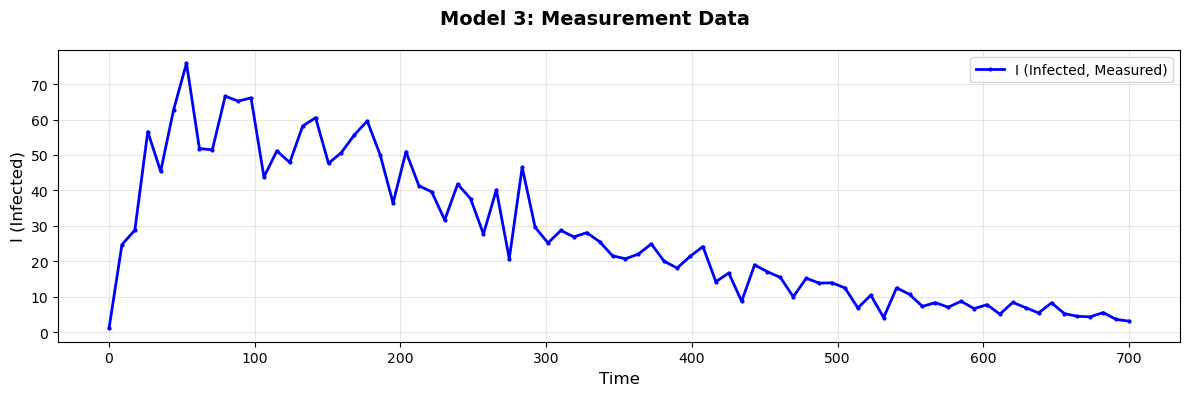

In [78]:
# Visualize data
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Only plot I since that's what we observed
i_idx = OBSERVED_INDICES[0]
ax.plot(t, y_noisy[:, i_idx], 'b.-', label='I (Infected, Measured)', linewidth=2, markersize=4)
ax.set_ylabel('I (Infected)', fontsize=12)
ax.set_xlabel('Time', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Model 3: Measurement Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 2. Build UDE Model


In [79]:
# Create neural network
nn_model = create_neural_network(
    input_dim=NN_INPUT_DIM,
    output_dim=NN_OUTPUT_DIM,
    architecture=NN_ARCHITECTURE,
    **NN_CONFIG
)

# Initialize weights with very small values to prevent initial instability
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=0.01)  # Very small gain
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

nn_model.apply(init_weights)

print("Neural Network:")
print(nn_model)
print(f"\nParameters: {nn_model.count_parameters():,}")


Neural Network:
FlexibleNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Tanh()
    (10): Linear(in_features=256, out_features=1, bias=True)
    (11): Softplus(beta=1.0, threshold=20.0)
  )
)

Parameters: 263,937


In [80]:
# Wrap NN to extract correct input from state vector
class NNWrapper(nn.Module):
    def __init__(self, nn, input_extractor, input_scale=100.0, output_min=0.0001, output_max=0.01):
        super().__init__()
        self.nn = nn
        self.input_extractor = input_extractor
        self.input_scale = input_scale  # Normalize I to roughly [0, 1]
        self.output_min = output_min    # Minimum beta value
        self.output_max = output_max    # Maximum beta value
    
    def forward(self, t, y):
        nn_input = self.input_extractor(y)
        # Normalize input (I is typically 0-100)
        nn_input_normalized = nn_input / self.input_scale
        # NN outputs in [0, 1] due to sigmoid
        nn_output = self.nn(t, nn_input_normalized)
        # Scale to desired beta range
        beta = self.output_min + (self.output_max - self.output_min) * nn_output
        return beta

wrapped_nn = NNWrapper(nn_model, nn_input_extractor)

# Create a custom UDE class that handles the learnable parameter correctly
class Model3UDE(nn.Module):
    def __init__(self, base_ude, initial_gamma=0.001):
        super().__init__()
        self.base_ude = base_ude
        # Store parameter, use abs to ensure gamma > 0
        self.gamma_learnable = nn.Parameter(torch.tensor(initial_gamma))
    
    def forward(self, t, y):
        # Use abs to ensure gamma stays positive (simpler than softplus)
        gamma_positive = torch.abs(self.gamma_learnable) + 1e-6  # Add small epsilon
        # Update known_params with constrained gamma value before calling the ODE function
        self.base_ude.known_params['gamma_learnable'] = gamma_positive
        return self.base_ude(t, y)
    
    def get_gamma(self):
        """Get the actual (constrained) gamma value"""
        return torch.abs(self.gamma_learnable) + 1e-6
    
    def count_parameters(self):
        counts = self.base_ude.count_parameters()
        counts['gamma'] = 1
        counts['total'] += 1
        return counts

# Create base UDE
base_ude = create_ude(
    n_states=len(STATE_NAMES),
    ode_func=ude_ode_equations,
    neural_networks={NN_NAME: wrapped_nn},
    known_params=KNOWN_PARAMS
)

# Wrap it with the custom class that handles gamma properly
# Start with small gamma value (will be constrained to positive via abs)
ude_model = Model3UDE(base_ude, initial_gamma=0.001)

print(f"\n✓ UDE Model created!")
print(f"  NN parameters: {ude_model.count_parameters()['total']}")
print(f"  Initial gamma: {ude_model.get_gamma().item():.4f}")



✓ UDE Model created!
  NN parameters: 263938
  Initial gamma: 0.0010


## 3. Train UDE


In [81]:
# Convert to tensors
t_torch = torch.tensor(t, dtype=torch.float32)
y_noisy_torch = torch.tensor(y_noisy, dtype=torch.float32)
y_true_torch = torch.tensor(y_true, dtype=torch.float32)
y0_torch = torch.tensor(y0, dtype=torch.float32)

# Create trainer
trainer = UDETrainer(
    ude_model=ude_model,
    optimizer_name=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    scheduler_type=SCHEDULER_TYPE,
    scheduler_params=SCHEDULER_PARAMS,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    ode_solver=ODE_SOLVER,
    ode_rtol=ODE_RTOL,
    ode_atol=ODE_ATOL
)

print("✓ Trainer initialized")


✓ Trainer initialized


/opt/miniconda3/envs/himanshu-quant-research/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [82]:
# Train!
print(f"\n{'='*60}")
print(f"TRAINING ({N_EPOCHS} epochs)")
print(f"{'='*60}\n")

# Convert weights to tensor if provided
weights_torch = torch.tensor(STATE_WEIGHTS, dtype=torch.float32) if STATE_WEIGHTS is not None else None

trainer.train(
    y0=y0_torch,
    t=t_torch,
    y_true=y_noisy_torch,
    n_epochs=N_EPOCHS,
    weights=weights_torch,
    loss_type=LOSS_TYPE,
    print_every=PRINT_EVERY
)

print(f"\n✓ Training complete!")
print(f"  Learned gamma: {ude_model.get_gamma().item():.4f}")



TRAINING (500 epochs)

Starting training for 500 epochs...
Optimizer: Adam
Learning rate: 0.0001
ODE solver: rk4

Epoch 1/500 | Loss: 1900.049072 | LR: 0.000100 | Grad: 1560691.2500
Epoch 50/500 | Loss: 169.568756 | LR: 0.000100 | Grad: 7142.3101
Epoch 100/500 | Loss: 131.963470 | LR: 0.000100 | Grad: 276.8141
Epoch 150/500 | Loss: 35.988037 | LR: 0.000100 | Grad: 1433.7997
Epoch 200/500 | Loss: 35.495872 | LR: 0.000100 | Grad: 151.6460
Epoch 250/500 | Loss: 34.829826 | LR: 0.000100 | Grad: 522.6848
Epoch 300/500 | Loss: 33.776958 | LR: 0.000100 | Grad: 936.4453
Epoch 350/500 | Loss: 31.970295 | LR: 0.000100 | Grad: 400.4229
Epoch 400/500 | Loss: 30.243713 | LR: 0.000100 | Grad: 333.9907
Epoch 450/500 | Loss: 30.181519 | LR: 0.000100 | Grad: 100.5832
Epoch 500/500 | Loss: 30.181372 | LR: 0.000100 | Grad: 424.5285

Training complete!
Final loss: 30.181372

✓ Training complete!
  Learned gamma: 0.0050


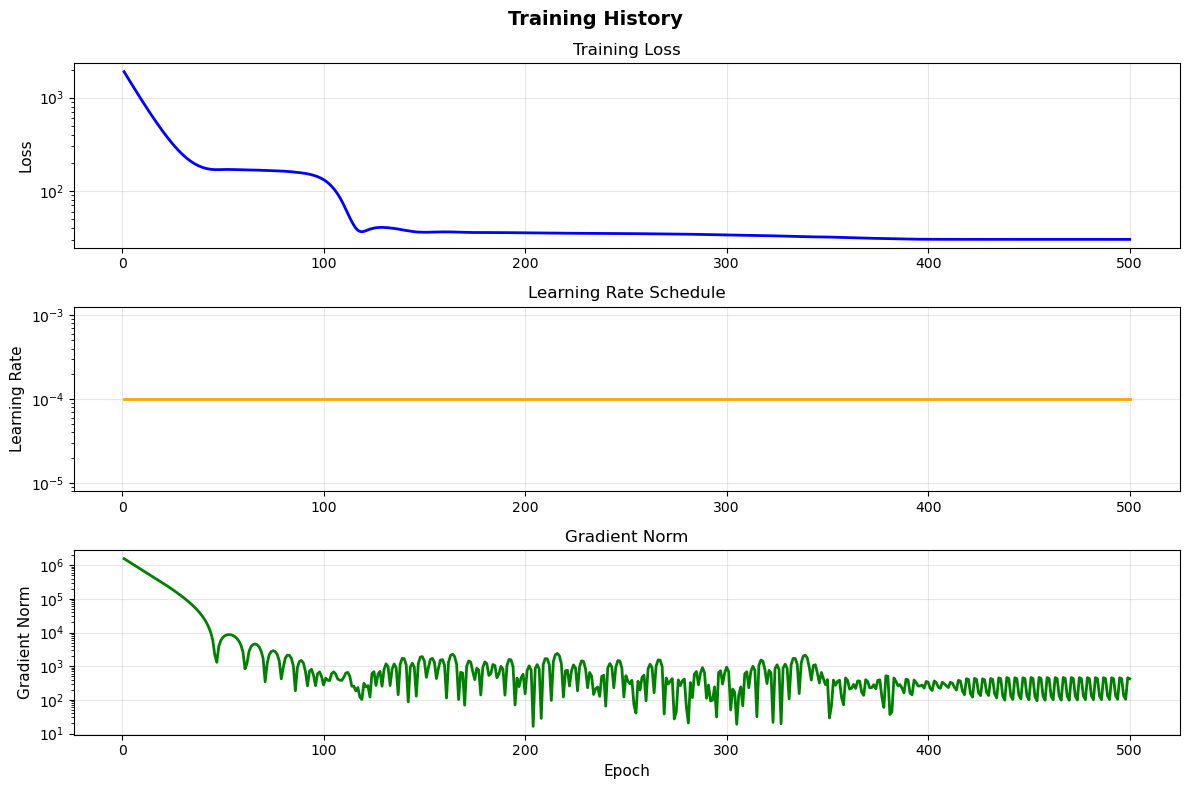

In [83]:
# Plot training history
history = trainer.get_history()
evaluator = UDEEvaluator(ude_model, STATE_NAMES)
evaluator.plot_training_history(history)


## 4. Evaluate UDE Performance


In [84]:
# Get predictions
with torch.no_grad():
    y_pred = trainer.forward_solve(y0_torch, t_torch).numpy()

# Compute metrics (only for I, the observed state)
i_idx = OBSERVED_INDICES[0]
mse = np.mean((y_pred[:, i_idx] - y_true[:, i_idx])**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred[:, i_idx] - y_true[:, i_idx]))

print(f"\n{'='*60}")
print("PREDICTION METRICS (for I - Infected)")
print(f"{'='*60}")
print(f"  MSE:  {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")
print(f"{'='*60}")



PREDICTION METRICS (for I - Infected)
  MSE:  30.179779
  RMSE: 5.493613
  MAE:  3.916760


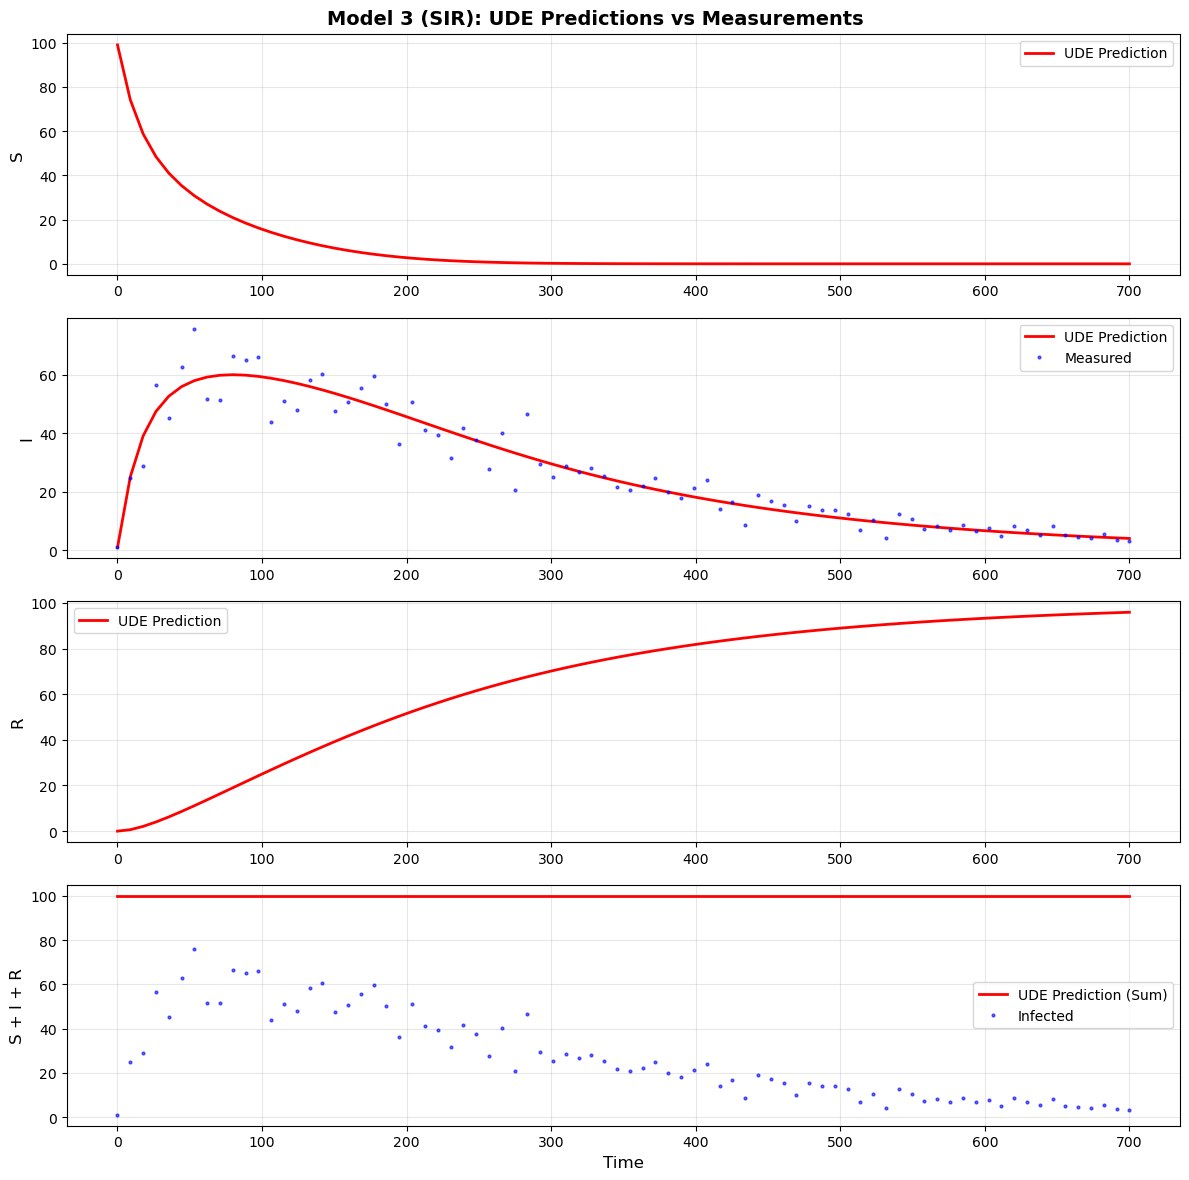

In [92]:
# Plot trajectories (all 3 states: S, I, R) plus their sum
fig, axes = plt.subplots(4, 1, figsize=(12, 12))

for i, (ax, name) in enumerate(zip(axes[:3], STATE_NAMES)):
    ax.plot(t, y_pred[:, i], 'r-', label='UDE Prediction', linewidth=2)
    
    # Only plot measurements for I (infected)
    if i == i_idx:
        ax.plot(t, y_true[:, i], 'b.', label='Measured', alpha=0.6, markersize=4)
    
    ax.set_ylabel(name, fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

# Plot sum of all three states
sum_pred = np.sum(y_pred, axis=1)
sum_true = np.sum(y_true, axis=1)
axes[3].plot(t, sum_pred, 'r-', label='UDE Prediction (Sum)', linewidth=2)
axes[3].plot(t, sum_true, 'b.', label='Infected', alpha=0.6, markersize=4)
axes[3].set_ylabel('S + I + R', fontsize=12)
axes[3].legend()
axes[3].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time', fontsize=12)
plt.suptitle('Model 3 (SIR): UDE Predictions vs Measurements', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Visualize Learned Function f(P)


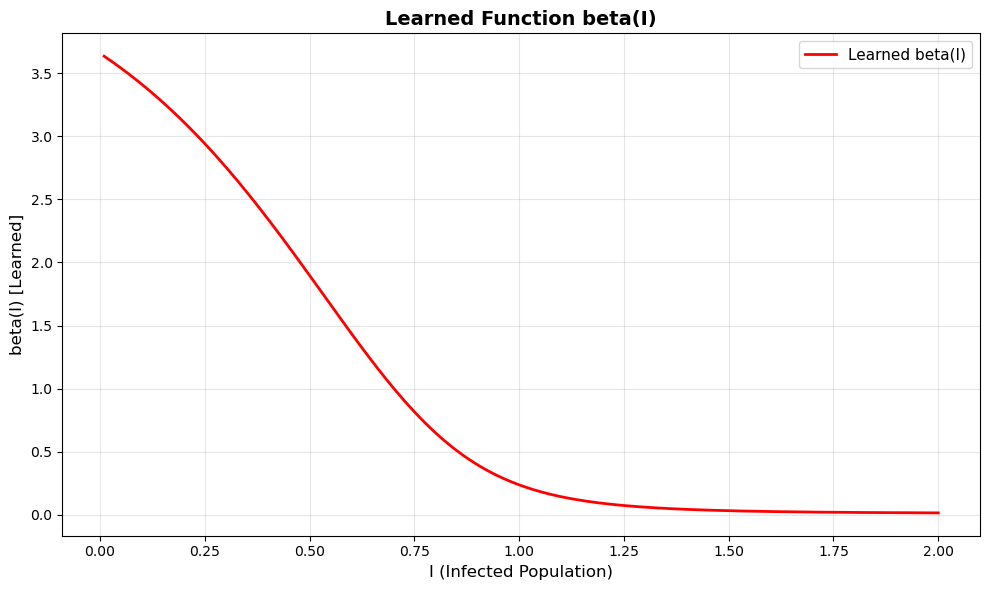

In [86]:
# Visualize the learned beta(I) function
# Create input: I values ranging from near 0 to max observed I
I_range = np.linspace(0.01, 2.0, 300)  # Range of I values
I_input = torch.tensor(I_range.reshape(-1, 1), dtype=torch.float32)

with torch.no_grad():
    beta_learned = nn_model(torch.zeros(len(I_range)), I_input).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(I_range, beta_learned, 'r-', linewidth=2, label='Learned beta(I)')
ax.set_xlabel('I (Infected Population)', fontsize=12)
ax.set_ylabel('beta(I) [Learned]', fontsize=12)
ax.set_title('Learned Function beta(I)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Parameter Summary


In [87]:
# Display learned parameters
print("\n" + "="*60)
print("LEARNED PARAMETERS")
print("="*60)
print(f"\nParameter gamma (recovery rate):")
print(f"  Learned value: {ude_model.get_gamma().item():.4f}")
print("\nNeural Network beta(I):")
print(f"  Total parameters: {nn_model.count_parameters()}")
print("  Architecture: 1 -> [32 x 6 layers] -> 1")
print("  Activation: tanh")
print("  Input: I (Infected population)")
print("="*60)



LEARNED PARAMETERS

Parameter gamma (recovery rate):
  Learned value: 0.0050

Neural Network beta(I):
  Total parameters: 263937
  Architecture: 1 -> [32 x 6 layers] -> 1
  Activation: tanh
  Input: I (Infected population)
